In [27]:
import numpy as np
from tifffile import imread
from os import listdir
from pymatreader import read_mat
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from pathlib import Path
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import cv2

In [18]:
bin = Path("/Volumes/Data2/seandarcy/Sean/rufus/17_t5_wf/normal/tiffs/suite2p/plane0/data.bin")
#sound = Path("/Volumes/Data2/seandarcy/Sean/rufus/17_t5_wf/normal/sound_file_2022-07-12_16-39-18_cs_17_T5_s2")
stimHist = Path("/Volumes/Data2/seandarcy/Sean/rufus/17_t5_wf/normal/stimHistory_17t5.mat")
specs = Path("specs")

def sequence(start, end):
    res = []
    diff = 1
    x = start
    while x <= end:
        res.append(x)
        x += diff
    return res

class NeuralDataset(Dataset) :
#tiff_path is path to .tiff files containing widefield images
#spec_path is path to spectrograms
#timeStamps is .mat file that is stims x nReps, containing frame info
  def __init__(self, bin_path, spec_path, timeStamps, transforms = None):
    self.binary_path = bin_path
    self.specs = listdir(spec_path)
    self.timeStamps = read_mat(timeStamps)['stimHistory']
    self.transform = transforms
  
  def __len__(self):
    return len(self.specs)

  def __getitem__(self, idx):
    reps = []
    for i in range(2) :
        start = self.timeStamps[idx, i]

        #load 30 image stack, tiffs in 9798 n stacks
        neu = np.fromfile(self.binary_path, dtype = np.uint16, count = 330*330*30, offset = (start - 1) * 330*330)
        img = np.reshape(neu,newshape=(330,330,-1),order='F')
        reps.append(ToTensor()(img.astype(float)))

    neurons = torch.stack((reps[0], reps[1]), 0)
    #print(neurons.shape)
    spec = torchvision.io.read_image("specs/" + self.specs[idx])
    #neurons = torch.stack((reps[0], reps[1]), 0)
    return neurons, spec


dataset = NeuralDataset(bin, specs, stimHist)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

#for i, (neurons, specs) in enumerate(dataloader):
        #print("Excerpt", i, "from Valley of the Yucas by Rufus du Sol")
        #img = specs.detach()
        #img = F.to_pil_image(img)
        #plt.imshow(np.asarray(img))

torch.Size([2, 30, 330, 330])
torch.Size([3, 875, 1167])


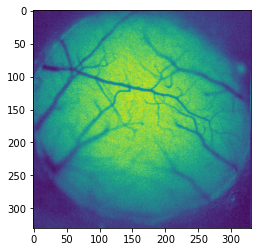

In [32]:
neu, spec = dataset[0]
#print(neu)

#shape is [repetition (2) x frame (30) x H x W]
#Transpose is correct

print(neu.shape)
print(spec.shape)
plt.imshow(neu[1, 0, :,:].T)


torch.Size([2, 30, 330, 330])


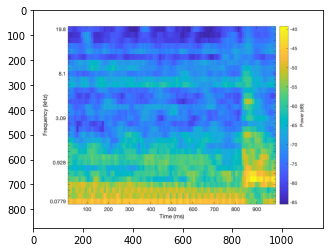

In [141]:
print(neu.shape)

img = spec.detach()
img = F.to_pil_image(img)
plt.imshow(np.asarray(img))

In [25]:
#to use for normalization

for i in range(226):
    neu, spec = dataset[i]
    recording = neu[0]
    if i == 0 :
        max = recording.max().item()
        min = recording.min().item()
    else :
        tmpMx = recording.max().item()
        tmpmin = recording.min().item()
        if tmpmin < min :
            min = tmpmin
        if tmpMx > max :
            max = tmpMx

    print(min, max)

881.0 1614.0
875.0 1614.0
875.0 1658.0
870.0 1658.0
870.0 1658.0
844.0 1658.0
844.0 1658.0
844.0 1658.0
844.0 1658.0
844.0 1658.0
844.0 1658.0
844.0 1658.0
844.0 1658.0
844.0 1658.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1678.0
844.0 1681.0
844.0 1681.0
844.0 1681.0
844.0 1681.0
844.0 1681.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
844.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1686.0
815.0 1761.0
815.0 1761.0

In [61]:
#fps = 30.0
#capSize = (330,330) 

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('outputs/797_rep1.mp4', fourcc, 30.0, (330,  330))
specOut = cv2.VideoWriter('outputs/specs.mp4', fourcc, 1.0, (1167, 875))

for i in range(226) :
    print((i/226), "complete.")
    neu, spec = dataset[i]
    recording = neu[0]

    for k in range(30) :
        img = recording[k].T.numpy()
        img = (img).astype(np.float32)

        img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
        #max or 3500
        img = 255.0 * ((img - min) / (max - min))
        img = (img).astype(np.uint8)
       
        out.write(img)


    spec = spec.detach()
    spec = cv2.cvtColor(np.moveaxis(np.asarray(spec), 0, -1),cv2.COLOR_RGB2BGR)
    spec = (spec).astype(np.uint8)
    specOut.write(spec)

out.release()
specOut.release()

0.0 complete.
0.004424778761061947 complete.
0.008849557522123894 complete.
0.01327433628318584 complete.
0.017699115044247787 complete.
0.022123893805309734 complete.
0.02654867256637168 complete.
0.030973451327433628 complete.
0.035398230088495575 complete.
0.03982300884955752 complete.
0.04424778761061947 complete.
0.048672566371681415 complete.
0.05309734513274336 complete.
0.05752212389380531 complete.
0.061946902654867256 complete.
0.06637168141592921 complete.
0.07079646017699115 complete.
0.0752212389380531 complete.
0.07964601769911504 complete.
0.084070796460177 complete.
0.08849557522123894 complete.
0.09292035398230089 complete.
0.09734513274336283 complete.
0.10176991150442478 complete.
0.10619469026548672 complete.
0.11061946902654868 complete.
0.11504424778761062 complete.
0.11946902654867257 complete.
0.12389380530973451 complete.
0.12831858407079647 complete.
0.13274336283185842 complete.
0.13716814159292035 complete.
0.1415929203539823 complete.
0.14601769911504425 co